In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pypalettes import load_cmap
from highlight_text import fig_text, ax_text
from drawarrow import ax_arrow

## Load Dataset

Load and aggregate data into **daily** road accidents.


In [2]:
url = "https://raw.githubusercontent.com/anw-g01/dataviz-anw/refs/heads/main/road_safety_open_data_2016/data/road_accidents.csv"

df = pd.read_csv(url, parse_dates=["date_time"], date_format="%Y-%m-%d %H:%M:%S")

df = (
    df.drop_duplicates(subset=["index"])    # filter for one accident per row
    .groupby("Area_Name")
    .agg(
        num_accidents=("index", "count"),               # count the no. of entries (accidents) per area
        population=("Population", "first")              # retain population data (constant throughout)
    )
    .reset_index(names="area_name")                     # renaming for consistency

    # calculate normalised metric: no. accidents per 1000
    .assign(accidents_per_1000=lambda df: df["num_accidents"] / df["population"] * 1000)
    .sort_values(
        by="accidents_per_1000",
        ascending=False
    )
)

df

,area_name,num_accidents,population,accidents_per_1000
36,City of London,368,9401.0,39.144772
196,Westminster,1545,247614.0,6.239550
89,Kensington and Chelsea,694,156726.0,4.428110
95,Lambeth,1268,327910.0,3.866915
73,Hammersmith and Fulham,646,179654.0,3.595801
...,...,...,...,...
169,Stockport,227,290557.0,0.781258
112,Moray,74,96070.0,0.770272
0,Aberdeen City,173,229840.0,0.752698
197,Wigan,237,323060.0,0.733610


## Scatter Plot - Population Size vs Accident Rates

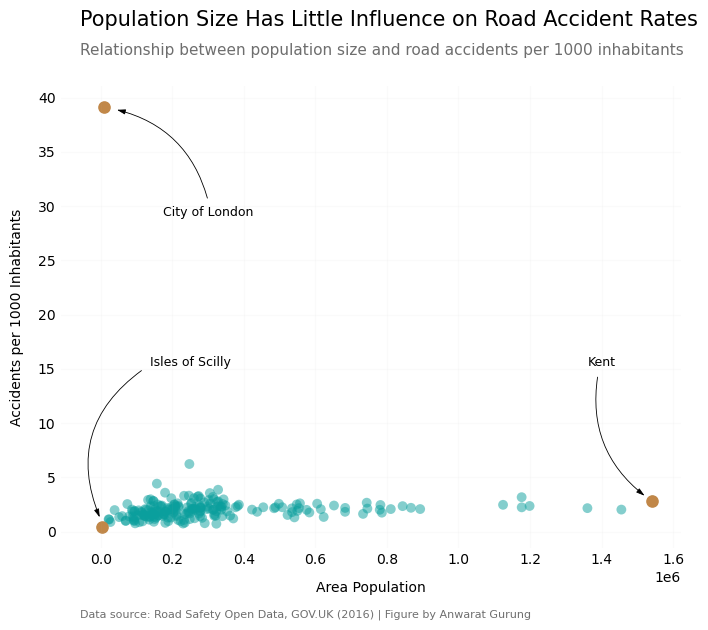

In [29]:
# choose a colour palette
cmap = load_cmap("AsteroidCity1")
colours = cmap.colors

# create figure
fig, ax1 = plt.subplots(figsize=(8, 6))

# axes customisation
ax1.set_ylabel("Accidents per 1000 Inhabitants", labelpad=10)
ax1.set_xlabel("Area Population", labelpad=10)
ax1.grid(True, alpha=0.05)
ax1.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax1.tick_params(length=0)

# create a scatter plot
marker_size = 50
ax1.scatter(
    df["population"],
    df["accidents_per_1000"],
    s=marker_size,
    c=colours[0],
    alpha=0.5,
    edgecolors="none"
)

# annotations to highlight key data points
idx_max_rate = df["accidents_per_1000"].idxmax()
idx_max_pop = df["population"].idxmax()
row_max_rate, row_max_pop = df.loc[idx_max_rate], df.loc[idx_max_pop]
area_rate, area_pop = row_max_rate["area_name"], row_max_pop["area_name"]
pop_rate, pop_pop = row_max_rate["population"], row_max_pop["population"]
rate_rate, rate_pop = row_max_rate["accidents_per_1000"], row_max_pop["accidents_per_1000"]

# lowest number data point
idx_min_rate = df["accidents_per_1000"].idxmin()
row_min_rate = df.loc[idx_min_rate]
area_min_rate = row_min_rate["area_name"]
pop_min_rate = row_min_rate["population"]
rate_min_rate = row_min_rate["accidents_per_1000"]

ax1.scatter(
    [pop_rate, pop_pop, pop_min_rate],
    [rate_rate, rate_pop, rate_min_rate],
    c=colours[4],
    s=int(marker_size * 1.3)
)
ax1.text(
    x=0.3e6,
    y=30,
    s=f"{area_rate}",    # City of London
    ha="center",
    va="top",
    fontsize=9
)
ax1.text(
    x=1.4e6,
    y=15,
    s=f"{area_pop}",    # Kent
    ha="center",
    va="bottom",
    fontsize=9
)

ax1.text(
    x=0.25e6,
    y=15,
    s=f"{area_min_rate}",    #
    ha="center",
    va="bottom",
    fontsize=9
)


# draw arrows to annotate key data points
ax_arrow(    # for highest rate
    tail_position=[0.3e6, 30.5],
    head_position=[pop_rate * 4, rate_rate * 0.995],
    fill_head=True,
    head_width=1.5,
    head_length=5,
    color="black",
    radius=0.3,
    width=0.6,
    ax=ax1
)
ax_arrow(    # for biggest population
    tail_position=[1.39e6, 14.5],
    head_position=[pop_pop * 0.99, rate_pop * 1.1],
    fill_head=True,
    head_width=1.5,
    head_length=5,
    color="black",
    radius=0.3,
    width=0.6,
    ax=ax1
)
ax_arrow(    # for lowest rate
    tail_position=[0.12e6, 15],
    head_position=[pop_min_rate * 0, rate_min_rate * 2.5],
    fill_head=True,
    head_width=1.5,
    head_length=5,
    color="black",
    radius=0.4,
    width=0.6,
    ax=ax1
)

x_value, y_value = 0.15, 0.98    # starting location of title text in figure coordinates
fig.text(
    x=x_value,
    y=y_value,
    s="Population Size Has Little Influence on Road Accident Rates",
    fontsize=15
)

# chart subtitle
fig.text(
    x=x_value,
    y=y_value * 0.95,
    s="Relationship between population size and road accidents per 1000 inhabitants",
    size=11,
    color="#6e6e6e"
)

# chart caption
fig.text(
    x_value, -0.01,
    "Data source: Road Safety Open Data, GOV.UK (2016) | Figure by Anwarat Gurung",
    ha="left",
    va="bottom",
    fontsize=8,
    color="#6e6e6e",
)

plt.savefig("../images/population_vs_accident_rates.png", dpi=200, bbox_inches="tight")

plt.show()

Removing `City of London` as an outlier for better resolution:

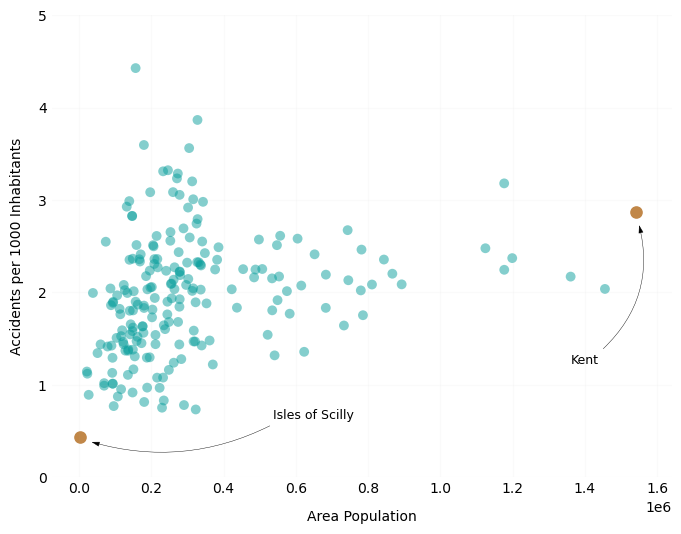

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))

# axes customisation
ax.set_ylim(0, 5)
ax.set_ylabel("Accidents per 1000 Inhabitants", labelpad=10)
ax.set_xlabel("Area Population", labelpad=10)
ax.grid(True, alpha=0.05)
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.tick_params(length=0)

# base scatter
ax.scatter(
    df["population"],
    df["accidents_per_1000"],
    s=marker_size,
    c=colours[0],
    alpha=0.5,
    edgecolors="none"
)

# re-plot highlighted points
ax.scatter(
    [pop_rate, pop_pop, pop_min_rate],
    [rate_rate, rate_pop, rate_min_rate],
    c=colours[4],
    s=int(marker_size * 1.3)
)

# text labels (same positions as original)
ax.text(
    x=1.4e6,
    y=1.2,
    s=f"{area_pop}",
    ha="center",
    va="bottom",
    fontsize=9
)

ax.text(
    x=0.65e6,
    y=0.6,
    s=f"{area_min_rate}",
    ha="center",
    va="bottom",
    fontsize=9
)

# arrows (excluding City of London arrow, as it is off-scale)
ax_arrow(
    tail_position=[1.445e6, 1.37],
    head_position=[pop_pop * 1.004, rate_pop * 0.96],
    fill_head=True,
    head_width=1.5,
    head_length=5,
    color="black",
    radius=0.3,
    width=0.3,
    ax=ax
)
ax_arrow(
    tail_position=[0.535e6, 0.57],
    head_position=[pop_min_rate * 12, rate_min_rate * 0.9],
    fill_head=True,
    head_width=1.5,
    head_length=5,
    color="black",
    radius=-0.2,
    width=0.3,
    ax=ax
)

plt.show()
